# Introduction

The aim is to practice what I have learned:exploring the data, Imputing missing values,Label/one hot encoding categorical variables, random forest and XGBoosting models. I start from the basic and gradually improve the models. The mean_absolute_error has been decreased from 17,906 to 15,355.

My future work will be to improve the feature enginnering by Box Cox Transformation of skewed features, applied more models  and use the model ensambling 




# 1. Exploratory Data Analysis

* Each row in the dataset describes the characteristics of a house.
* Our goal is to predict the SalePrice, given these features.

In [1]:
# Essentials
import numpy as np
import pandas as pd

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.stats import f_oneway

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

# Display all columns
pd.options.display.max_columns=None
home_data = pd.read_csv('train.csv')
home_data_competition=pd.read_csv('test.csv')

home_data.head()



,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [2]:
home_data_competition.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [3]:
print('The traning data shape:')
print(home_data.shape)

print('The competition data shape:')
print(home_data_competition.shape)


The traning data shape:
(1460, 81)
The competition data shape:
(1459, 80)


## 1.1 Analyse the target: SalePrice

In [4]:
home_data.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

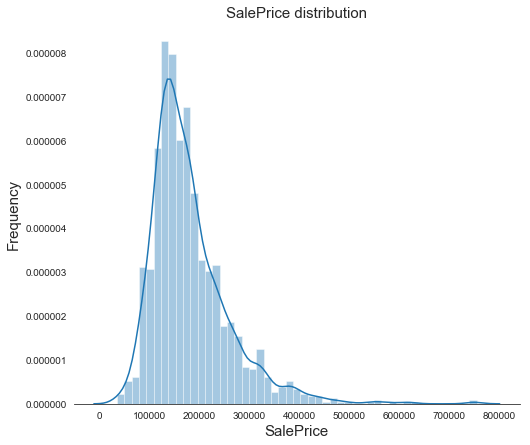

In [5]:
sns.set_style("white")               #separate each bar
plt.subplots(figsize=(8, 7))         #set figure size
sns.distplot(home_data['SalePrice'])
plt.ylabel("Frequency",fontsize=15)
plt.xlabel("SalePrice",fontsize=15)
plt.title("SalePrice distribution",fontsize=15)
sns.despine(left=True)               #remove the frame


In [6]:
#skewness and kurtosis
print("Skewness:{}".format(home_data['SalePrice'].skew()))
print("Kurtosis:{}".format(home_data['SalePrice'].kurt()))

Skewness:1.8828757597682129
Kurtosis:6.536281860064529


In [7]:
home_data['SalePrice'].isnull().sum()

0

1 There is no missing values from the target.
2 The Sale price is right skewed, need to be converted to normal distribution when do the ML

In [8]:
home_data['SalePrice']=np.log1p(home_data['SalePrice'])

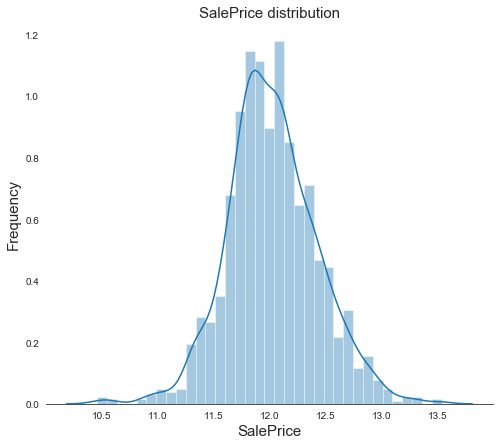

In [9]:
sns.set_style("white")               #separate each bar
plt.subplots(figsize=(8, 7))         #set figure size
sns.distplot(home_data['SalePrice'])
plt.ylabel("Frequency",fontsize=15)
plt.xlabel("SalePrice",fontsize=15)
plt.title("SalePrice distribution",fontsize=15)
sns.despine(left=True)               #remove the frame


## 1.2 Explore numerical and categorical features

In [10]:
#group numeric features
numeric=home_data.select_dtypes(include=(np.number)).columns
print(numeric)
print("There are {} numeric features".format(len(numeric)))

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
There are 38 numeric features


In [11]:
#group categorical features
categ=home_data.select_dtypes(exclude=(np.number)).columns
#convert "object" to "category"
home_data[categ]=home_data[categ].astype('category')
print(categ)
print("There are {} category features".format(len(categ)))

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
There are 43 category features


### Numeric Features - Scatter plot 

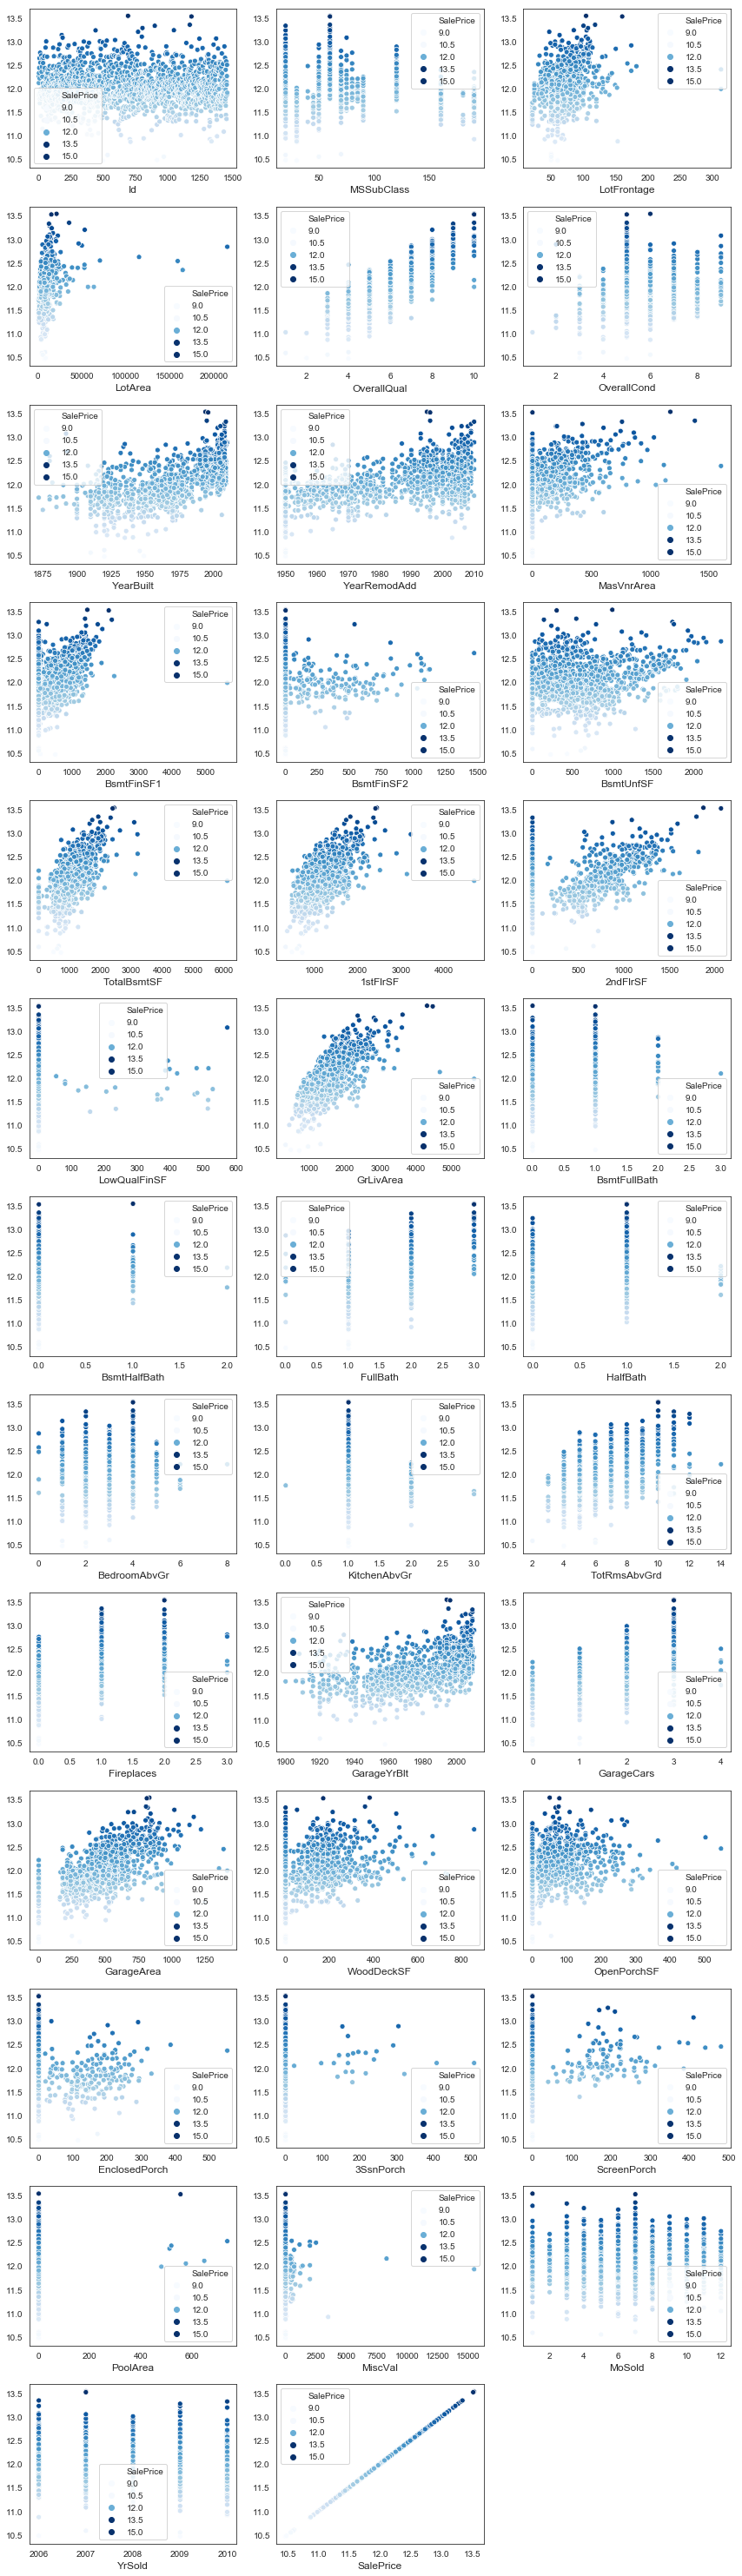

In [12]:
# visualising numerical features vs SalePrice   
plt.subplots(figsize=(12, 120))
#plt.subplots_adjust(hspace=0.3,wspace=0.2,right=2,top=1)
for i, feature in enumerate(home_data[numeric], 1):      #enumerate:print index and the relevant value ,star from 1
    plt.subplot(len(numeric), 3, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Blues', data=home_data)    
    plt.xlabel('{}'.format(feature), fontsize=12)
    plt.ylabel('')
    plt.legend(loc='best',prop={'size': 10})
plt.tight_layout()        
plt.show()

In [13]:
home_data[numeric].describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,12.024057
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,0.399449
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,10.460271
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,11.775105
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,12.001512
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,12.273736
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,13.534474


There are some outliers and there are a lot variance between max and min values. We will use standard sacle to transform the data.

### Numeric Features - Distribution

In [14]:
#Distributions of numerical features
f=pd.melt(home_data,value_vars=sorted(numeric))
f.head()


,variable,value
0,1stFlrSF,856.0
1,1stFlrSF,1262.0
2,1stFlrSF,920.0
3,1stFlrSF,961.0
4,1stFlrSF,1145.0


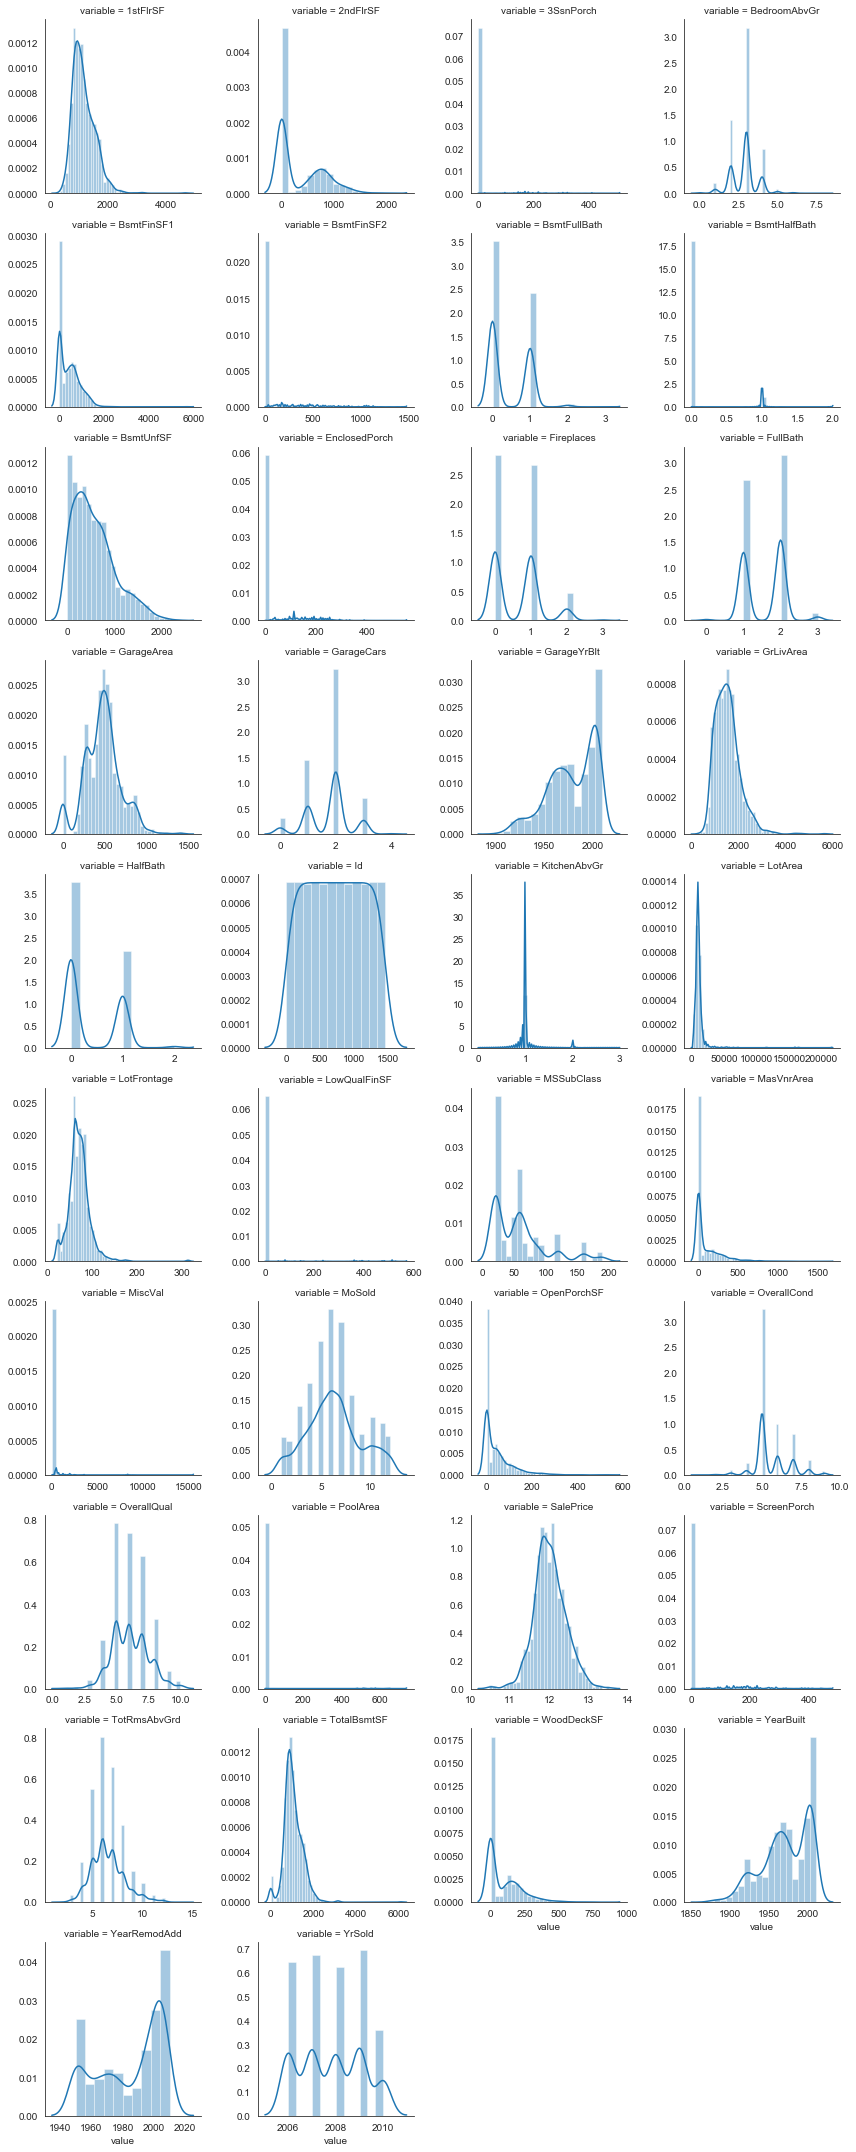

In [15]:
g=sns.FacetGrid(f,col='variable',col_wrap=4,sharex=False,sharey=False)
g=g.map(sns.distplot,'value')

There are some independent variables look like good candidates for log transformation: TotalBsmtSF, KitchenAbvGr, LotFrontage, LotArea, GarageArea 1stFlrSF and FrLivArea. 

### Numeric Features - Heatmap

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5, 36.5]), <a list of 37 Text yticklabel objects>)

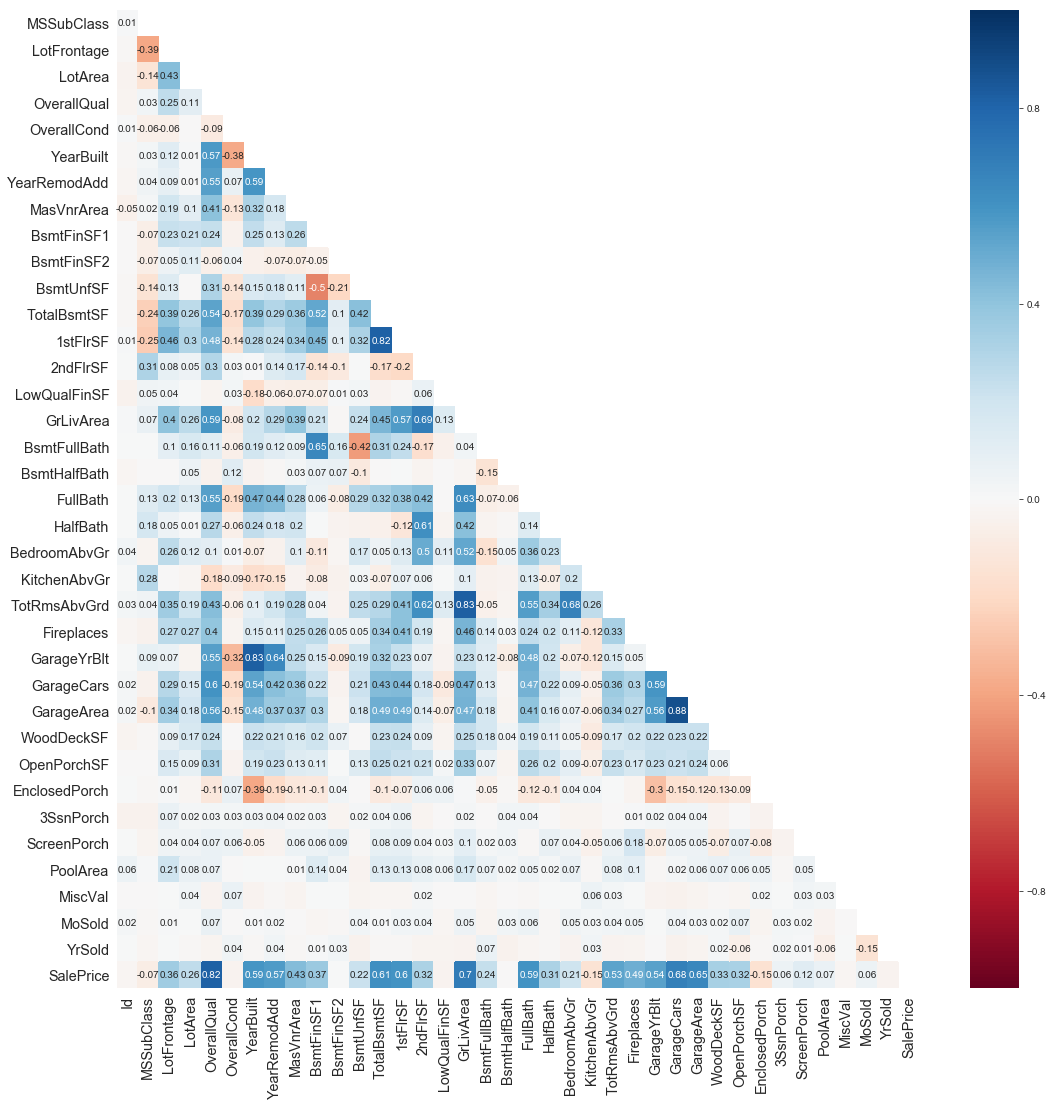

In [16]:
# create a triangular mask to avoid repeated values 
# and make the plot easier to read
corr = home_data[numeric].corr().iloc[1:]
mask = np.triu(np.ones_like(corr), k=1)

plt.figure(figsize=(18,18))
ax=sns.heatmap(corr, vmin=-1, vmax=1, cmap='RdBu', mask=mask,annot=True)
# format the text in the plot to make it easier to read
for text in ax.texts:
    t = float(text.get_text())
    if -0.05 < t < 0.01:
        text.set_text('')
    else:
        text.set_text(round(t, 2))
plt.xticks(rotation=90,size='x-large')
plt.yticks(rotation=0,size='x-large')


The heatmap also indicates there are some features have the great effect on the SalePrice

### Category Features - Boxplot

In [17]:
f=pd.melt(home_data,id_vars='SalePrice',value_vars=sorted(categ))
f.head()

,SalePrice,variable,value
0,12.247699,Alley,NaN
1,12.109016,Alley,NaN
2,12.317171,Alley,NaN
3,11.849405,Alley,NaN
4,12.429220,Alley,NaN


/Users/Josh1/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


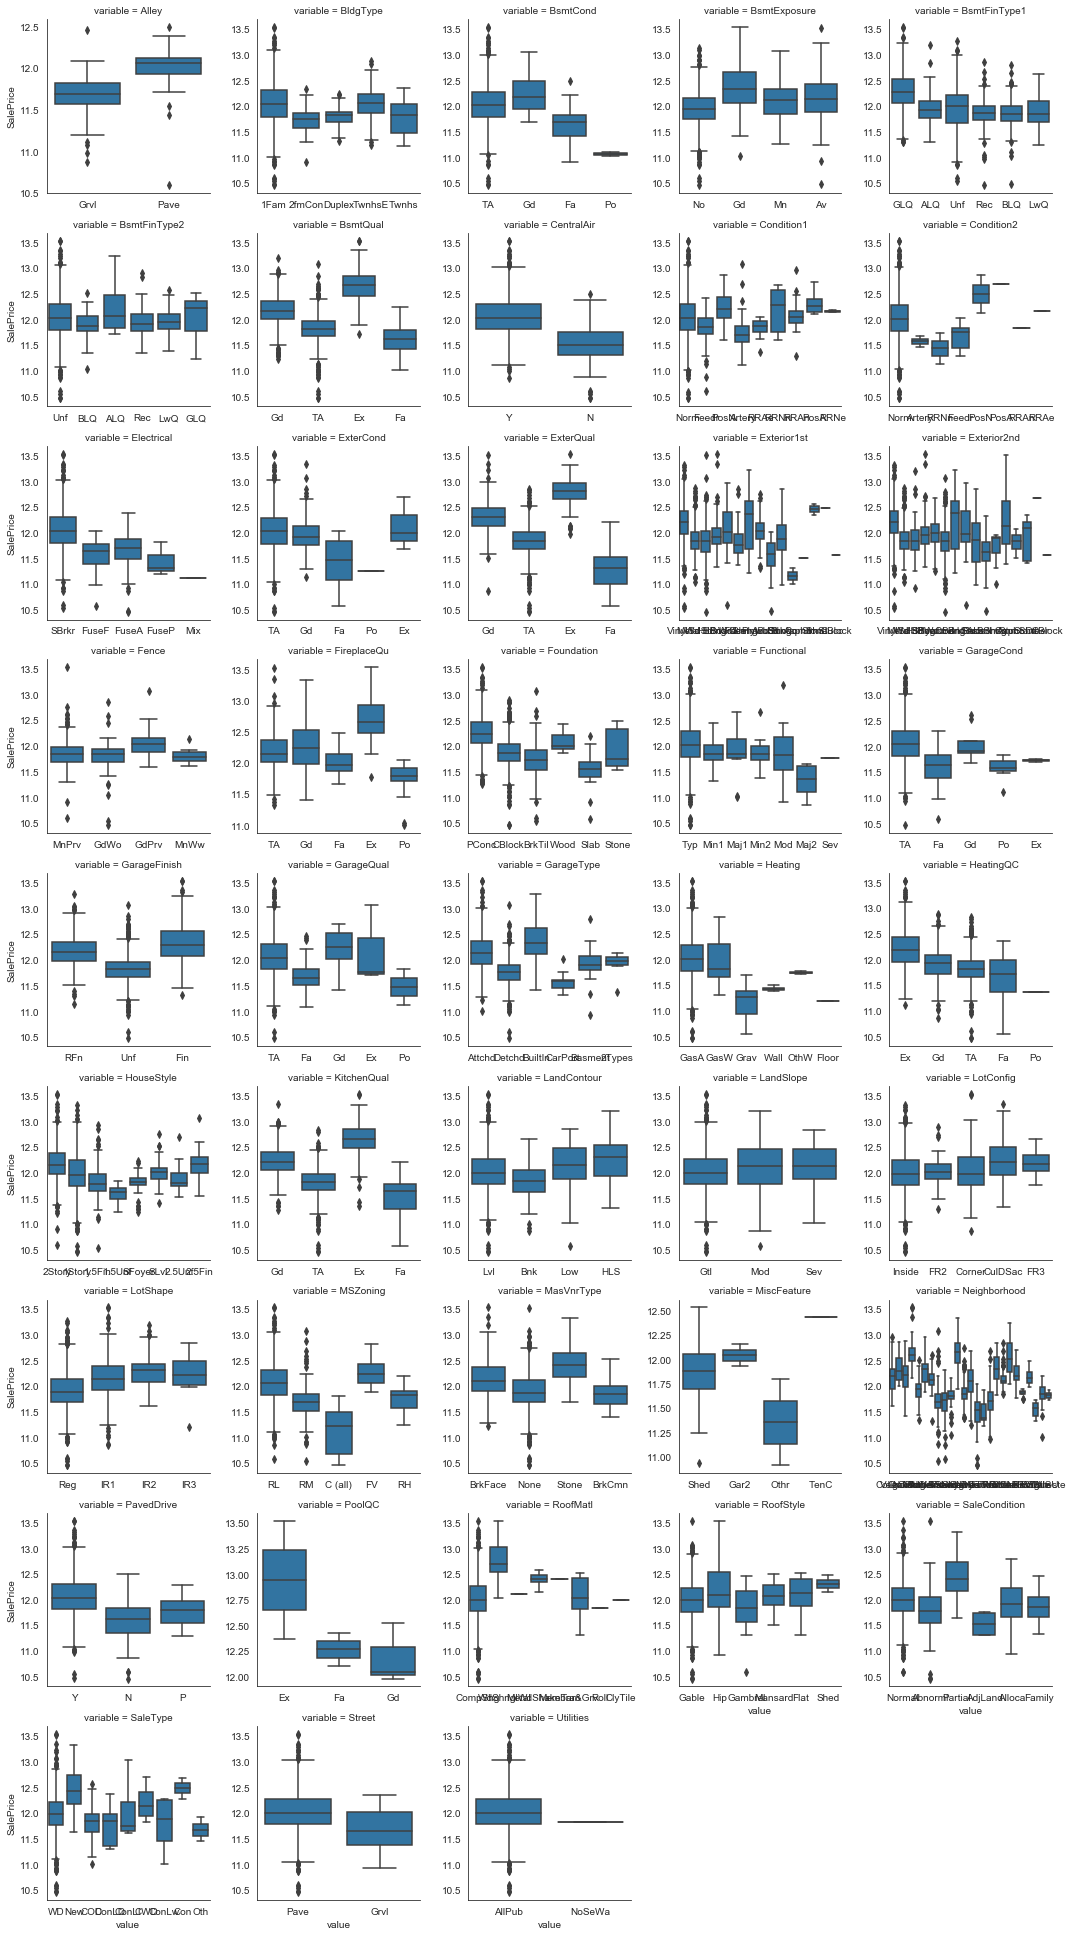

In [18]:
g=sns.FacetGrid(f,col='variable',col_wrap=5,sharex=False,sharey=False)
g=g.map(sns.boxplot,'value','SalePrice')
g.fig.tight_layout()

Some Categorical features have great effect on the saleprice: BsmtQual,Condition2,Neighborhood and others

### Category Features - ANOVA

In [19]:
# fillna with 'missing' since ANOVA will have error for NaN
home_data_anova=home_data.copy()
for cat in categ:
    home_data_anova[cat] = home_data_anova[cat].cat.add_categories('Missing').fillna('Missing')

# fit ANOVA    
anova={'feature':[],'f':[],'p':[]}
for cat in categ:
    group_price=[]
    for group in home_data_anova[cat].unique():
        group_price.append(home_data_anova[home_data_anova[cat]==group]['SalePrice'].values)
    f,p=f_oneway(*group_price)
    anova['feature'].append(cat)
    anova['f'].append(f)
    anova['p'].append(p)
anova=pd.DataFrame(anova,columns=['feature','f','p'])
anova.sort_values('p',inplace=True)
anova

,feature,f,p
8,Neighborhood,79.520526,4.041201e-243
18,ExterQual,415.304259,6.930372e-195
21,BsmtQual,300.392915,2.029970e-188
30,KitchenQual,393.320922,4.438817e-187
34,GarageFinish,298.769591,4.058066e-151
33,GarageType,121.796238,8.430356e-125
32,FireplaceQu,131.198588,6.961918e-115
20,Foundation,126.806779,1.350599e-111
27,HeatingQC,110.820423,1.614912e-82
24,BsmtFinType1,71.381818,4.320809e-78


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 <a list of 43 Text xticklabel objects>)

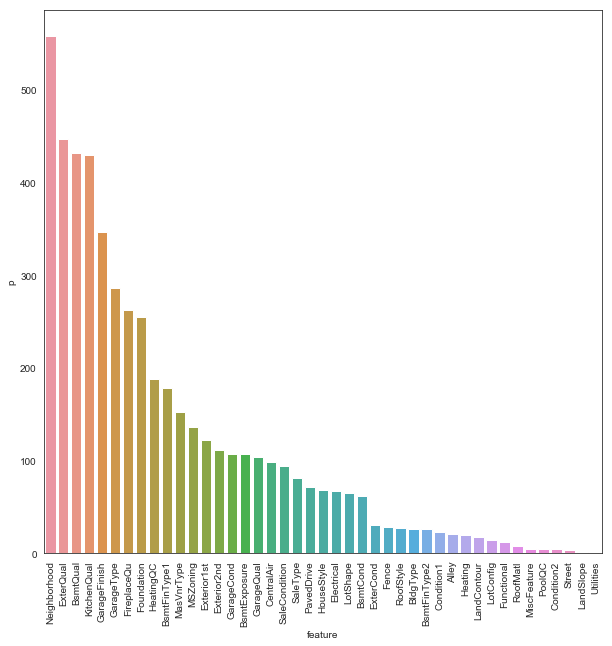

In [20]:
plt.figure(figsize=(10,10))
sns.barplot(anova['feature'],np.log(1./anova['p']))  ## transfer p for better visualisation
plt.xticks(rotation=90)


Here is ANOVA analysis on the influence of categorical variable on SalePrice. The test shows the same results to boxplot

## 1.3 Handle missing values and sacel the numerical features for all data 

In [21]:
#concatenate the train and test data in the same dataframe
ntrain = home_data.shape[0]
ntest = home_data_competition.shape[0]
all_data = pd.concat((home_data, home_data_competition),sort=False).reset_index(drop=True)
all_data.drop(['SalePrice','Id'], axis=1, inplace=True)
print("All_data size is : {}".format(all_data.shape))

All_data size is : (2919, 79)


In [22]:
missing_counts=all_data[categ].isnull().sum()/all_data.shape[0]*100
missing_counts=missing_counts[missing_counts>0]
missing_counts.sort_values(ascending=False)


PoolQC          99.657417
MiscFeature     96.402878
Alley           93.216855
Fence           80.438506
FireplaceQu     48.646797
GarageCond       5.447071
GarageQual       5.447071
GarageFinish     5.447071
GarageType       5.378554
BsmtExposure     2.809181
BsmtCond         2.809181
BsmtQual         2.774923
BsmtFinType2     2.740665
BsmtFinType1     2.706406
MasVnrType       0.822199
MSZoning         0.137033
Functional       0.068517
Utilities        0.068517
Exterior1st      0.034258
SaleType         0.034258
Exterior2nd      0.034258
KitchenQual      0.034258
Electrical       0.034258
dtype: float64

## Missing values for numerical features

In [23]:
#drop all features with more than 40% missing values
all_data.drop(columns=['PoolQC','MiscFeature','Alley','Fence','FireplaceQu'],inplace=True)

In [24]:
missing_columns= all_data.isnull().sum()[home_data.isnull().sum()>0].index

In [25]:
all_data[missing_columns].select_dtypes(include=np.number).head()

,LotFrontage,MasVnrArea,GarageYrBlt
0,65.0,196.0,2003.0
1,80.0,0.0,1976.0
2,68.0,162.0,2001.0
3,60.0,0.0,1998.0
4,84.0,350.0,2000.0


In [26]:
# MasVnrArea already has 0, so replace nan with 0
all_data['MasVnrArea']=all_data['MasVnrArea'].replace(np.NaN,0)

# to minimise the effect of outliers, we inpute median to replace null values for other two features
from sklearn.impute import SimpleImputer
imputer_median=SimpleImputer(strategy='median')
all_data[['LotFrontage','GarageYrBlt']]=imputer_median.fit_transform(all_data[['LotFrontage','GarageYrBlt']])


## Missing values for categorical features

In [27]:
missing_columns=all_data.isnull().sum()[all_data.isnull().sum()>0].index
# we inpute most_frequent to replace null values for all categorical features
imputer_median=SimpleImputer(strategy='most_frequent')
all_data[missing_columns]=imputer_median.fit_transform(all_data[missing_columns])

In [28]:
all_data.isnull().sum().sum()

0

## Scale the numerical features

In [29]:
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal


In [30]:
all_data.select_dtypes(include=np.number).columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

there are some should be categorical features whcich should not be scaled : OverallQual,OverallCond,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,MoSold

In [31]:
all_data[['OverallQual','OverallCond','YearBuilt','YearRemodAdd','GarageYrBlt','YrSold','MoSold']]=\
all_data[['OverallQual','OverallCond','YearBuilt','YearRemodAdd','GarageYrBlt','YrSold','MoSold']].astype('category',inplace=True)

In [32]:
numeric_col=all_data.select_dtypes(include=(np.number)).columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
all_data[numeric_col]=scaler.fit_transform(all_data[numeric_col])
all_data[numeric_col].head()

,MSSubClass,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,0.067331,-0.191815,-0.217879,0.529034,0.581145,-0.293025,-0.934165,-0.443078,-0.773861,1.207379,-0.101197,0.413547,1.087334,-0.249719,0.781366,1.232599,0.169927,-0.207698,0.986849,-0.924311,0.306418,0.349364,-0.740760,0.200006,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592
1,-0.873616,0.511940,-0.072044,-0.567016,1.178255,-0.293025,-0.629284,0.477463,0.261075,-0.785025,-0.101197,-0.471891,-0.818929,3.822508,0.781366,-0.756321,0.169927,-0.207698,-0.287758,0.623632,0.306418,-0.058991,1.614879,-0.702843,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592
2,0.067331,-0.051064,0.137197,0.338903,0.098189,-0.293025,-0.287999,-0.297968,-0.610718,1.235375,-0.101197,0.563755,1.087334,-0.249719,0.781366,1.232599,0.169927,-0.207698,-0.287758,0.623632,0.306418,0.627787,-0.740760,-0.081209,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592
3,0.302568,-0.426400,-0.078385,-0.567016,-0.494529,-0.293025,-0.046824,-0.669812,-0.506205,0.978742,-0.101197,0.427382,1.087334,-0.249719,-1.027363,-0.756321,0.169927,-0.207698,0.349546,0.623632,1.619830,0.785561,-0.740760,-0.184815,3.874967,-0.103331,-0.285935,-0.06315,-0.089592
4,0.067331,0.699608,0.518903,1.390216,0.469187,-0.293025,-0.160586,0.212184,-0.037170,1.671651,-0.101197,1.378042,1.087334,-0.249719,0.781366,1.232599,1.385655,-0.207698,1.624153,0.623632,1.619830,1.685798,0.776967,0.540424,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592


In [33]:
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.067331,RL,-0.191815,-0.217879,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,0.529034,Gd,TA,PConc,Gd,TA,No,GLQ,0.581145,Unf,-0.293025,-0.934165,-0.443078,GasA,Ex,Y,SBrkr,-0.773861,1.207379,-0.101197,0.413547,1.087334,-0.249719,0.781366,1.232599,0.169927,-0.207698,Gd,0.986849,Typ,-0.924311,Attchd,2003.0,RFn,0.306418,0.349364,TA,TA,Y,-0.740760,0.200006,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592,2,2008,WD,Normal
1,-0.873616,RL,0.511940,-0.072044,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,-0.567016,TA,TA,CBlock,Gd,TA,Gd,ALQ,1.178255,Unf,-0.293025,-0.629284,0.477463,GasA,Ex,Y,SBrkr,0.261075,-0.785025,-0.101197,-0.471891,-0.818929,3.822508,0.781366,-0.756321,0.169927,-0.207698,TA,-0.287758,Typ,0.623632,Attchd,1976.0,RFn,0.306418,-0.058991,TA,TA,Y,1.614879,-0.702843,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592,5,2007,WD,Normal
2,0.067331,RL,-0.051064,0.137197,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,0.338903,Gd,TA,PConc,Gd,TA,Mn,GLQ,0.098189,Unf,-0.293025,-0.287999,-0.297968,GasA,Ex,Y,SBrkr,-0.610718,1.235375,-0.101197,0.563755,1.087334,-0.249719,0.781366,1.232599,0.169927,-0.207698,Gd,-0.287758,Typ,0.623632,Attchd,2001.0,RFn,0.306418,0.627787,TA,TA,Y,-0.740760,-0.081209,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592,9,2008,WD,Normal
3,0.302568,RL,-0.426400,-0.078385,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,-0.567016,TA,TA,BrkTil,TA,Gd,No,ALQ,-0.494529,Unf,-0.293025,-0.046824,-0.669812,GasA,Gd,Y,SBrkr,-0.506205,0.978742,-0.101197,0.427382,1.087334,-0.249719,-1.027363,-0.756321,0.169927,-0.207698,Gd,0.349546,Typ,0.623632,Detchd,1998.0,Unf,1.619830,0.785561,TA,TA,Y,-0.740760,-0.184815,3.874967,-0.103331,-0.285935,-0.06315,-0.089592,2,2006,WD,Abnorml
4,0.067331,RL,0.699608,0.518903,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,1.390216,Gd,TA,PConc,Gd,TA,Av,GLQ,0.469187,Unf,-0.293025,-0.160586,0.212184,GasA,Ex,Y,SBrkr,-0.037170,1.671651,-0.101197,1.378042,1.087334,-0.249719,0.781366,1.232599,1.385655,-0.207698,Gd,1.624153,Typ,0.623632,Attchd,2000.0,RFn,1.619830,1.685798,TA,TA,Y,0.776967,0.540424,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592,12,2008,WD,Normal


## onehot encoding for category features

In [34]:
## onehot encoding for category features
all_data=all_data.copy()
all_data=pd.get_dummies(all_data)
all_data.head()

,MSSubClass,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual_1,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10,OverallCond_1,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,YearBuilt_1872,YearBuilt_1875,YearBuilt_1879,YearBuilt_1880,YearBuilt_1882,YearBuilt_1885,YearBuilt_1890,YearBuilt_1892,YearBuilt_1893,YearBuilt_1895,YearBuilt_1896,YearBuilt_1898,YearBuilt_1900,YearBuilt_1901,YearBuilt_1902,YearBuilt_1904,YearBuilt_1905,YearBuilt_1906,YearBuilt_1907,YearBuilt_1908,YearBuilt_1910,YearBuilt_1911,YearBuilt_1912,YearBuilt_1913,YearBuilt_1914,YearBuilt_1915,YearBuilt_1916,YearBuilt_1917,YearBuilt_1918,YearBuilt_1919,YearBuilt_1920,YearBuilt_1921,YearBuilt_1922,YearBuilt_1923,YearBuilt_1924,YearBuilt_1925,YearBuilt_1926,YearBuilt_1927,YearBuilt_1928,YearBuilt_1929,YearBuilt_1930,YearBuilt_1931,YearBuilt_1932,YearBuilt_1934,YearBuilt_1935,YearBuilt_1936,YearBuilt_1937,YearBuilt_1938,YearBuilt_1939,YearBuilt_1940,YearBuilt_1941,YearBuilt_1942,YearBuilt_1945,YearBuilt_1946,YearBuilt_1947,YearBuilt_1948,YearBuilt_1949,YearBuilt_1950,YearBuilt_1951,YearBuilt_1952,YearBuilt_1953,YearBuilt_1954,YearBuilt_1955,YearBuilt_1956,YearBuilt_1957,YearBuilt_1958,YearBuilt_1959,YearBuilt_1960,YearBuilt_1961,YearBuilt_1962,YearBuilt_1963,YearBuilt_1964,YearBuilt_1965,YearBuilt_1966,YearBuilt_1967,YearBuilt_1968,YearBuilt_1969,YearBuilt_1970,YearBuilt_1971,YearBuilt_1972,YearBuilt_1973,YearBuilt_1974,YearBuilt_1975,YearBuilt_1976,YearBuilt_1977,YearBuilt_1978,YearBuilt_1979,YearBuilt_1980,YearBuilt_1981,YearBuilt_1982,YearBuilt_1983,YearBuilt_1984,YearBuilt_1985,YearBuilt_1986,YearBuilt_1987,YearBuilt_1988,YearBuilt_1989,YearBuilt_1990,YearBuilt_1991,YearBuilt_1992,YearBuilt_1993,YearBuilt_1994,YearBuilt_1995,YearBuilt_1996,YearBuilt_1997,YearBuilt_1998,YearBuilt_1999,YearBuilt_2000,YearBuilt_2001,YearBuilt_2002,YearBuilt_2003,YearBuilt_2004,YearBuilt_2005,YearBuilt_2006,YearBuilt_2007,YearBuilt_2008,YearBuilt_2009,YearBuilt_2010,YearRemodAdd_1950,YearRemodAdd_1951,YearRemodAdd_1952,YearRemodAdd_1953,YearRemodAdd_1954,YearRemodAdd_1955,YearRemodAdd_1956,YearRemodAdd_1957,YearRemodAdd_1958,YearRemodAdd_1959,YearRemodAdd_1960,YearRemodAdd_1961,YearRemodAdd_1962,YearRemodAdd_1963,YearRemodAdd_1964

In [35]:
print(all_data.shape)

(2919, 581)


## 1.5 Modelling

In [36]:
# spit all_data to obtain the tainnig and test data
X = all_data[0:ntrain]
y = home_data['SalePrice'].values
competition = all_data[ntrain:]

In [120]:
# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)
# Applied cross validation to test the model
def rmse(model,X,y):
    cv_score=cross_val_score(model, X,y, scoring='neg_mean_squared_error',cv=10)
    final_score= np.mean(np.sqrt(np.abs(cv_score)))
    return final_score

## Lesso model to detemine important features

In [38]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Print out 'Lesso's hyperparameters
print(Lasso().get_params())

{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


In [121]:
#define the grid for hyperparameters "params_dt"
param_grid={
            'alpha':[0.0001,0.001,0.01,0.1,1.,5.,10.,25.],
            'max_iter':[50000],
            'tol':[0.0001,0.001]
            }
lasso=GridSearchCV(Lasso(),cv=10,param_grid=param_grid, scoring='neg_mean_squared_error')   
lasso.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 5.0, 10.0,
                                   25.0],
                         'max_iter': [50000], 'tol': [0.0001, 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [122]:
# Extract best hyperparameters from 'lesso'
best_hyperparams = lasso.best_params_
print('Best hyerparameters:\n', best_hyperparams)

Best hyerparameters:
 {'alpha': 0.001, 'max_iter': 50000, 'tol': 0.0001}


In [123]:
#Extracting the best estimator
lasso = lasso.best_estimator_
print('Lesso -> Train MSE:{:.5f} | Test MSE:{:.5f}'.format(rmse(lasso, X_train,y_train), 
                                                           rmse(lasso, X_test,y_test)))

Lesso -> Train MSE:0.14339 | Test MSE:0.14461


* The error between training and test sets are pretty close which means the model has been overfited. 
* The important features has to be chosen rather than to include all features

In [89]:
lasso_coef=lasso.coef_
coefs=pd.DataFrame({'coefs':lasso_coef,"positive":lasso_coef>0},index=X_train.columns)
coefs['coefs_abs']=abs(coefs['coefs'])
picked_num=((lasso_coef)!=0).sum()
droped_num=((lasso_coef)==0).sum()
print('Lasso picked {} features and droped the other {} features'.format(picked_num,droped_num))
picked_features=coefs[coefs['positive']!=0].index

Lasso picked 106 features and droped the other 475 features


Text(0.5,1,'Lasso Regression:Top Features')

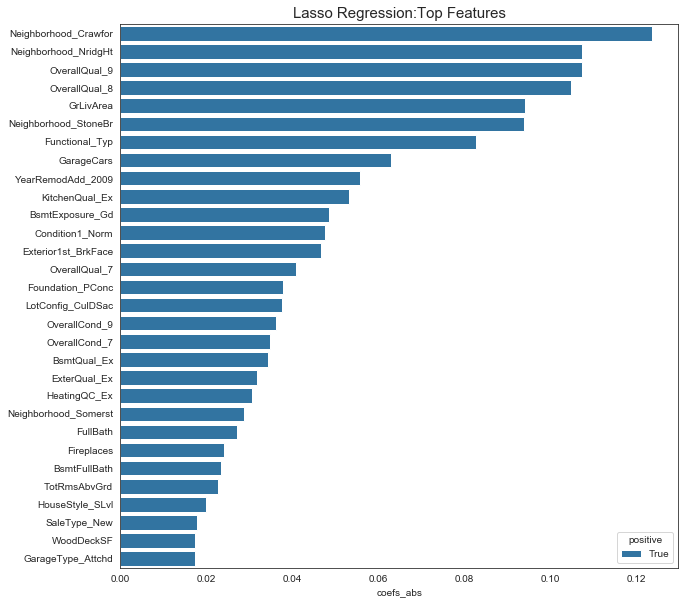

In [60]:
#visualize the top 30 important features
coefs=coefs[coefs.positive].sort_values(by='coefs_abs',ascending=False).head(30)
plt.figure(figsize=(10,10))
sns.barplot(x=coefs.coefs_abs,y=coefs.index,hue=coefs.positive)
plt.title('Lasso Regression:Top Features',fontsize=15)

The top 30 important features are all positively affect the price

## Random Forest with Lasso features

In [101]:
rf=RandomForestRegressor(random_state=1)
# to get hyperparameters
print(rf.get_params())

{'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 'warn', 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}


In [105]:
#model tunning: define the grid for hyperparameters "params_dt"
param_grid={
            'bootstrap': [True],
            'max_depth': [80, 90, 100, 110],
            'max_features': ['log2', 'sqrt'],
            'min_samples_leaf': [ 3, 4, 5],
            'min_samples_split': [8, 10, 12],
            'n_estimators': [100,300, 500]
            }
grid_rf=GridSearchCV(rf,cv=3,param_grid=param_grid,verbose=1,scoring='neg_mean_squared_error',n_jobs=-1) 

grid_rf.fit(X_train[picked_features],y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  2.5min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=1,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [8

In [114]:
# Extract best hyperparameters from 'rf'
best_hypeparams = grid_rf.best_params_
print('Best hyerparameters:\n', best_hypeparams)

Best hyerparameters:
 {'bootstrap': True, 'max_depth': 80, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}


In [115]:
# evaluate the performance
best_rf=grid_rf.best_estimator_
print('Random Forest -> Train MSE:{:.5f} | Test MSE:{:.5f}'.format(rmse(best_rf, X_train,y_train), 
                                                           rmse(best_rf, X_test,y_test)))

Random Forest -> Train MSE:0.16204 | Test MSE:0.18874


When reduce the features, the error increase, but the overfitting has been reduced

## XGBoost with Lesso features


In [116]:
from xgboost import XGBRegressor
xgb = XGBRegressor()

print(xgb.get_params)

<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)>


Parameter Tuning( n_estimators: 100-1000;early_stopping_rounds=5; learning_rate: 0.05-0.1;n_jobs=4

In [126]:
#model tunning: define the grid for hyperparameters "params_dt"
from sklearn.model_selection import RandomizedSearchCV
param_grid={
            'subsample': np.arange(.05, 1, .05),
            'max_depth': np.arange(3, 20, 1),
            'colsample_bytree': np.arange(.1,1.05,.05),
            'n_estimators': [100,300, 500]
            }
grid_xgb=RandomizedSearchCV(xgb,cv=4,param_distributions=param_grid,verbose=1,scoring='neg_mean_squared_error',n_jobs=-1,n_iter=10)  

grid_xgb.fit(X_train[picked_features],y_train)

print('Best score from tunned XGBoost:{}'.format(grid_xgb.best_score_)) 

# Extract best hyperparameters from 'rf'
best_hypeparams = grid_xgb.best_params_
print('Best hyerparameters:\n', best_hypeparams)



Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   16.9s finished


[22:08:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best score from tunned XGBoost:-0.017632733764624924
Best hyerparameters:
 {'subsample': 0.7000000000000001, 'n_estimators': 500, 'max_depth': 3, 'colsample_bytree': 0.30000000000000004}


In [128]:
# evaluate the performance
best_xgb=grid_xgb.best_estimator_
print('XGBoost -> Train MSE:{:.5f} | Test MSE:{:.5f}'.format(rmse(best_xgb, X_train,y_train), 
                                                           rmse(best_xgb, X_test,y_test)))

[22:11:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:12:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:12:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:12:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:12:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:12:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:12:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:12:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:12:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

## 1.6 Ensemble models by weighted average

In [144]:
#Lasso 
pred_lesso=np.expm1(lasso.predict(competition))

#Radom forest
pred_rf=np.expm1(best_rf.predict(competition[picked_features]))

#XGBoost
pred_xgb=np.expm1(best_xgb.predict(competition[picked_features]))

#weighted average

finalpred=(pred_lesso*0.3+pred_rf*0.3+pred_xgb*0.4)

#output for submission
output=pd.DataFrame({'Id':home_data_competition.Id,
                   'SalePrice':finalpred})
output.to_csv('submission.csv',index=False)